In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

sys.path.append("../")
from deepnets import nnModels as models
from deepnets import nnUtilities as nnutils

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

dataPath = None

Using device: cpu


In [2]:
run_id = '0'
root = '/Users/celiaberon/Desktop/'
save_path = os.path.join(root, 'runs', run_id)

In [31]:
def initialize_model(model_name='MLP4', actFunc=F.relu, pDropout=0):

    '''
    '''

    if model_name == 'CNN2P2':
        convActivation = actFunc
        linearActivation = actFunc
        net = models.CNN2P2(convActivation=convActivation,
                            linearActivation=linearActivation)

        preprocess = transforms.Compose([
            transforms.ToTensor(), # first, convert image to PyTorch tensor
            transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
        ])
    elif model_name == 'MLP3':
        net = models.MLP3(actFunc=actFunc)

        preprocess = transforms.Compose([
            transforms.ToTensor(), # first, convert image to PyTorch tensor
            transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
            transforms.Lambda(torch.flatten), # convert to vectors
        ])
    elif model_name == 'MLP4':
        net = models.MLP4(actFunc=actFunc,
                          pDropout=pDropout)

        preprocess = transforms.Compose([
            transforms.ToTensor(), # first, convert image to PyTorch tensor
            transforms.Normalize((0.1307,), (0.3081,)), # normalize inputs
            transforms.Lambda(torch.flatten), # convert to vectors
        ])
    elif model_name == 'AlexNet':
        # Initialize AlexNet with no pretrained weights.
        net = models.AlexNet(weights=None, pDropout=pDropout)
        preprocess = None
    else:
        raise ValueError('useNet not recognized')

    return net, preprocess

def prepare_loaders(dataset, **kwargs):

    if dataset == 'MNIST':
        trainloader, testloader, numClasses = nnutils.downloadMNIST(**kwargs)
    elif dataset == 'ImageNet-Tiny':
        trainloader, testloader, numClasses = nnutils.downloadImageNetTiny(**kwargs)
    elif dataset == 'ImageNet':
        trainloader, testloader, numClasses = nnutils.downloadImageNet(**kwargs)

    return trainloader, testloader, numClasses

def eval_test_performance(test_loader, trained_net, loss_function, DEVICE=None):

    if DEVICE is None:
        DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Measure performance on test set
    totalLoss = 0
    numCorrect = 0
    numAttempted = 0
    for images, label in test_loader:
        images, label = images.to(DEVICE), label.to(DEVICE)
        outputs = trained_net(images)
        totalLoss += loss_function(outputs, label).item()
        predictions = torch.argmax(outputs, axis=1)
        numCorrect += sum(predictions == label)
        numAttempted += images.shape[0]

    print(f'Average loss over test set: {(totalLoss / len(test_loader)):.2f}.')
    print(f'Accuracy over test set: {(100 * numCorrect / numAttempted):.2f}%.')


In [32]:
useNet='AlexNet'

# DataLoader params
batchSize = 1000
weightvars = None # initialize variance of weights with default parameters

# Training params
iterations=1
learningRate=3e-2
verbose=True
doInitWeights=False
pDropout=0.5

# First, select device to run networks on
if DEVICE is None:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CPU = 'cpu'
print(f'Initiating experiment using {DEVICE}')

Initiating experiment using cpu


In [33]:

# Prepare Network and Preprocessing
net, preprocess = initialize_model(model_name=useNet,
                                   actFunc=F.relu,
                                   pDropout=pDropout)
net.to(DEVICE)

# Prepare Dataloaders
trainloader, testloader, numClasses = prepare_loaders(dataset='ImageNet', batch_size=batchSize,
                                                      preprocess=preprocess, n_workers=2)

# Prepare Training Functions 
loss_function = nn.CrossEntropyLoss() # Note: this automatically applies softmax...
optimizer = torch.optim.SGD(net.parameters(), lr=learningRate)
# optimizer = torch.optim.Adadelta(net.parameters())

# Preallocate summary variables  
n_batches = len(trainloader)
numTrainingSteps = n_batches * iterations
trackLoss = torch.zeros(numTrainingSteps)
trackAccuracy = torch.zeros(numTrainingSteps)
align_full = torch.zeros(numTrainingSteps, net.numLayers, )
alignFull = []
alignFull_nodo = []
deltaWeights = []

# Store initial network weights to view how things change over training
initWeights = net.getNetworkWeights()

# Train Network & Measure Integration
t = time.time()
for epoch in range(0, iterations): 
    # Set current loss value
    currentLoss = 0.0
    numBatches = 0
    currentCorrect = 0
    currentAttempted = 0

    for idx, (images, label) in enumerate(trainloader):

        if idx > 0:
            continue
        print(idx)
        cidx = epoch * len(trainloader) + idx  # stores idx of each "miniepoch" 

        # move batch to GPU (if available) 
        images, label = images.to(DEVICE), label.to(DEVICE)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = net(images)

        # Perform backward pass & optimization
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        # Measure Alignment of weights using current images in batch as a sample
        alignFull.append(net.measureAlignment(images, usePrevious=True))
        with torch.no_grad():
            net.setDropout(0)
            alignFull_nodo.append(net.measureAlignment(images, usePrevious=False))
            net.setDropout(pDropout)

        # Measure Change in Weights
        deltaWeights.append(net.compareNetworkWeights(initWeights))

        # Measure alignment of change in weights

        # Track Loss and Accuracy
        trackLoss[cidx] = loss.item()
        trackAccuracy[cidx] = (100 * torch.sum(torch.argmax(outputs, axis=1) == label)
                                / images.shape[0])
        # Print statistics for each epoch
    if verbose: 
        print(f'Loss in epoch {epoch:3d}: {loss.item():.3f}, Accuracy: {trackAccuracy[cidx]:.2f}%')

# Measure performance on test set
eval_test_performance(testloader, trained_net=net, loss_function=loss_function, DEVICE=DEVICE)

print(f'Training process has finished in {(time.time() - t):.3f} seconds.')

results = {
    'net': net,
    'initWeights': initWeights,
    'alignFull': alignFull,
    'alignFull_nodo': alignFull_nodo,
    'deltaWeights': deltaWeights,
    'trackLoss': trackLoss,
    'trackAccuracy': trackAccuracy,
    'trainloader': trainloader,
    'testloader': testloader,
    'learningRate': learningRate,
}

RuntimeError: The archive ILSVRC2012_devkit_t12.tar.gz is not present in the root directory or is corrupted. You need to download it externally and place it in /Users/celiaberon/Documents/machine_learning/datasets/imagenet.

In [7]:
from torchvision import models
alexnet = models.alexnet(weights='DEFAULT', progress=True)

In [8]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
len(alignFull[0][3])

10

In [20]:
# (numLayers, numMiniEpochs) returns average alignment for each layer for each mini-epoch
# alignMean = net.avg_within_layer(alignFull) 
# alignMean_nodo = net.avg_within_layer(alignFull_nodo)

# [(numNodes, numMiniEpochs) for layer in numLayers] for each layer, return the alignment of each network node for each mini-epoch
alignLayer = [net.layerFromFull(alignFull,layer) for layer in range(net.numLayers)] 
alignLayer_nodo = [net.layerFromFull(alignFull_nodo,layer) for layer in range(net.numLayers)] 

alignMean = [layer.mean(axis=0) for layer in alignLayer]
alignMean_nodo = [layer.mean(axis=0) for layer in alignLayer_nodo]

In [21]:
[a.shape for a in  alignFull[0]]

[torch.Size([100]), torch.Size([100]), torch.Size([50]), torch.Size([10])]

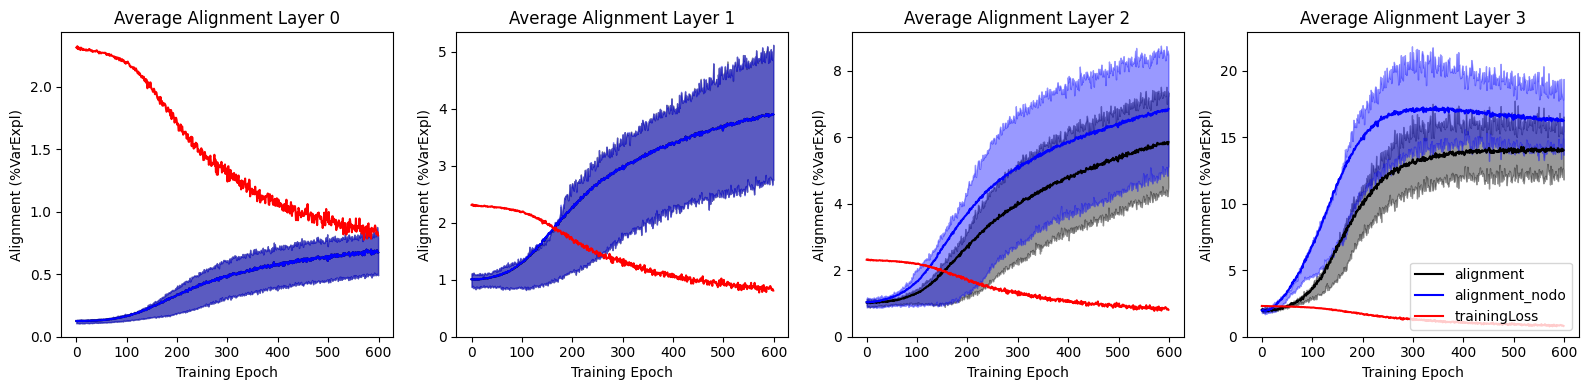

In [22]:
lb, ub = (0.3, 0.7)
fig, axs = plt.subplots(1, net.numLayers, figsize=(16,4))
for ax, layer in zip(axs, range(net.numLayers)):
   
    # get upper and lower quantile of alignment for each layer
    uq = torch.quantile(alignLayer[layer], q=ub, dim=0)
    lq = torch.quantile(alignLayer[layer], q=lb, dim=0)

    uqnd = torch.quantile(alignLayer_nodo[layer], q=ub, dim=0)
    lqnd = torch.quantile(alignLayer_nodo[layer], q=lb, dim=0)

    # plot average alignment for each layer (scale to % of variance)
    ax.plot(range(numTrainingSteps), 100 * alignMean[layer], 
            color='k', linewidth=1.5, label='alignment')
    ax.plot(range(numTrainingSteps), 100 * alignMean_nodo[layer], 
            color='b', linewidth=1.5, label='alignment_nodo')
    
    # plot quantile range of alignment for each layer (scale to % of variance)
    ax.fill_between(range(numTrainingSteps), 100 * uq, 100 * lq, color='k', alpha=0.4)
    ax.fill_between(range(numTrainingSteps), 100 * uqnd, 100 * lqnd, color='b', alpha=0.4)

    ax.plot(range(numTrainingSteps), trackLoss, color='r', linewidth=1.5, label='trainingLoss')

    ax.set_ylim(0)
    ax.set_xlabel('Training Epoch')
    ax.set_ylabel('Alignment (%VarExpl)')
    ax.set_title(f'Average Alignment Layer {layer}')
    
    if layer == net.numLayers - 1:
        ax.legend(loc='lower right')
    else:
        ax.legend().remove()
    
plt.tight_layout()

# fig.savefig(os.path.join(save_path, 'training_alignment.png'), bbox_inches='tight')

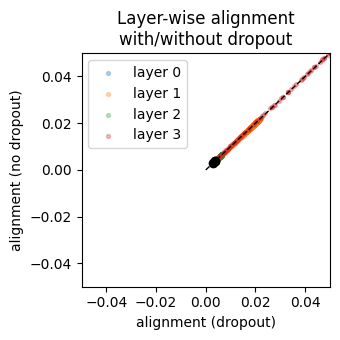

In [72]:
fig, ax = plt.subplots(figsize=(3.5,3.5))

ax.plot([0, 1], [0, 1], ls='--', lw=1, color='k')
for layer in range(net.numLayers):
    plt.scatter(alignLayer[layer].mean(axis=0),
                alignLayer_nodo[layer].mean(axis=0),
                label=f"layer {layer}", s=8, alpha=0.3)
    plt.scatter(alignLayer[layer].mean(axis=0)[0], alignMean_nodo[i][0], c='k')
    # plt.scatter(alignMean[i][60*30], alignMean_nodo[i][60*30], c='b')

plt.legend()
ax.set(xlim=(0, max(alignMean.max(), alignMean_nodo.max() + 0.03)),
       ylim=(0, max(alignMean.max(), alignMean_nodo.max() + 0.03)),
       xlabel='alignment (dropout)', ylabel='alignment (no dropout)',
       title='Layer-wise alignment\nwith/without dropout')

plt.tight_layout()

# fig.savefig(os.path.join(root, 'dropout_alignment.png'), bbox_inches='tight')

In [73]:
# Measure Activations (without dropout) for all images
storeDropout = net.getDropout()
net.setDropout(0) # no dropout for measuring eigenfeatures

allimages = []
activations = []
for images, label in tqdm(trainloader):    
    allimages.append(images)
    images, label = images.to(DEVICE), label.to(DEVICE)
    # this is a huge list of the activations across all layers for each image in the data
    activations.append(net.getActivations(images)) 
net.setDropout(storeDropout)

print('n batches = ', len(activations)) # number of batches in trainLoader
print('n layers = ', len(activations[0])) # number of layers in network
print([a.shape for a in activations[0]]) # (batchSize x nodesPerLayer) for each layer

100%|██████████| 60/60 [00:13<00:00,  4.53it/s]

n batches =  60
n layers =  4
[torch.Size([1000, 32, 14, 14]), torch.Size([1000, 64, 2, 2]), torch.Size([1000, 256]), torch.Size([1000, 10])]


In [ ]:
# 60
# 4
# [torch.Size([1000, 32, 14, 14]), torch.Size([1000, 64, 2, 2]), torch.Size([1000, 256]), torch.Size([1000, 10])]
# torch.Size([60000, 1, 28, 28])
# torch.Size([60000, 32, 14, 14])
# torch.Size([60000, 64, 2, 2])
# torch.Size([60000, 256])

In [93]:
allInputs[0][0]

NameError: name 'allInputs' is not defined

In [74]:
# Consolidate variable structure
# allinputs is a numLayers element list containing the input to each layer for every image
# the first element (allinputs[0]) is just the images
# every next element is the post-activations of each successive layer in the network

allinputs = []
allinputs.append(torch.cat(allimages, dim=0).detach().cpu())
for layer in range(net.numLayers - 1):
    
    allinputs.append(torch.cat([cact[layer] for cact in activations], dim=0).detach().cpu())
    
for ai in allinputs: print(ai.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 32, 14, 14])
torch.Size([60000, 64, 2, 2])
torch.Size([60000, 256])


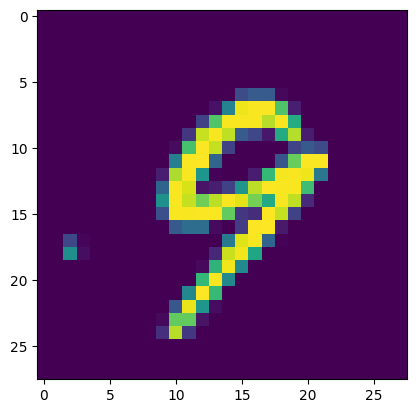

In [83]:
plt.imshow(torch.cat(allimages, dim=0).detach().cpu()[0][0])

In [75]:
# Measure eigenfeatures for each layer
# Now, we can measure the eigenvalues of the input to each layer
eigenvalues = []
eigenvectors = []
for ai in allinputs:
    w, v = sp.linalg.eigh(torch.cov(ai.T))
    widx = np.argsort(w)[::-1]
    w = w[widx]
    v = v[:,widx]
    eigenvalues.append(w)
    eigenvectors.append(v)
for evl, evc in zip(eigenvalues, eigenvectors):
    print(f'EVal Shape: {evl.shape}, EVec Shape: {evc.shape}')

/var/folders/bb/552md4fn27l5zpqklwc2jpf40000gn/T/ipykernel_46529/1072853299.py:6: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  w, v = sp.linalg.eigh(torch.cov(ai.T))


RuntimeError: cov(): expected input to have two or fewer dimensions but got an input with 4 dimensions

In [13]:
# Measure dot product of weights for each layer
# The dot product of the weight for each layer with the eigenvectors of the input to each layer
# tells us what fraction of the weight for each node comes from each eigenvector!
beta = []
netweights = net.getNetworkWeights()
for evc, nw in zip(eigenvectors, netweights):
    nw = nw / torch.norm(nw, dim=1, keepdim=True)
    beta.append(torch.abs(nw.cpu() @ evc))
for b in beta: print(b.shape)

torch.Size([100, 784])
torch.Size([100, 100])
torch.Size([50, 100])
torch.Size([10, 50])


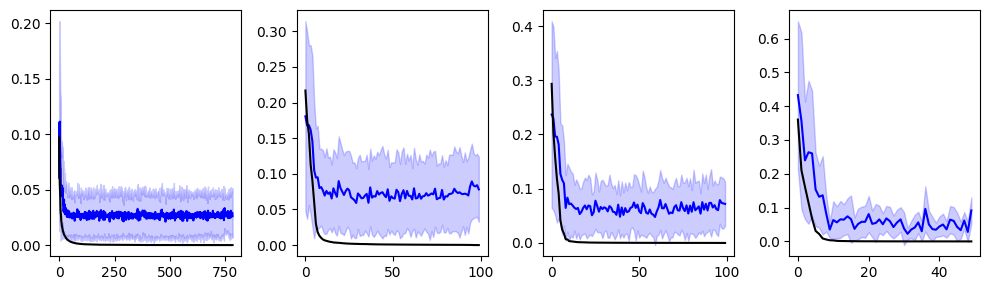

In [15]:
# Compare the eigenvalues of the input to each layer with the betas of the weight vectors for each eigenvector
# The black line is the eigenvalues. It tells us the variance structure of the input to each layer --
# -- specifically, it tells us which dimensions of the input contain significant variance
# The blue lines are the average +/- std dot product ("beta") between the weights of each layer and the eigenvectors of the input to each layer --

# Note: 
# note that the blue curve is a lot higher than the black curve -- that means that the network is using eigenvectors that explain very little variance!! (weird)
# ----- I think this might be relevant for understanding how adversarial attacks work...

fig, axs = plt.subplots(1, net.numLayers, figsize=(10,3))

for ax, layer in zip(axs, range(net.numLayers)):
    cNEV = len(eigenvalues[layer])
    mnbeta = torch.mean(beta[layer], dim=0)
    sebeta = torch.std(beta[layer], dim=0)
    ax.fill_between(range(cNEV), mnbeta + sebeta, mnbeta - sebeta, color='b', alpha=0.2)
    ax.plot(range(cNEV), mnbeta, c='b', label='AverageProjection')
    ax.plot(range(cNEV), eigenvalues[layer] / np.sum(eigenvalues[layer]), c='k', label='Eigenvalues')
    # ax.set_xscale('linear')
    # ax[layer].set_yscale('log')

plt.tight_layout()

In [58]:
import networkAlignment as na

Using device: cpu


Using device: cpu
Loss in epoch   0: 2.269, Accuracy: 15.20%
Loss in epoch   1: 2.168, Accuracy: 23.10%
Loss in epoch   2: 1.851, Accuracy: 36.50%
Loss in epoch   3: 1.566, Accuracy: 44.60%
Loss in epoch   4: 1.277, Accuracy: 56.20%
Loss in epoch   5: 1.157, Accuracy: 60.00%
Loss in epoch   6: 1.028, Accuracy: 64.20%
Loss in epoch   7: 0.996, Accuracy: 66.00%
Loss in epoch   8: 0.882, Accuracy: 69.70%
Loss in epoch   9: 0.837, Accuracy: 72.00%
Average loss over test set: 0.85.
Accuracy over test set: 72.50%.
Training process has finished in 254.543 seconds.


100%|██████████| 60/60 [00:23<00:00,  2.59it/s]


60
4
[torch.Size([1000, 100]), torch.Size([1000, 100]), torch.Size([1000, 50]), torch.Size([1000, 10])]
torch.Size([60000, 784])
torch.Size([60000, 100])
torch.Size([60000, 100])
torch.Size([60000, 50])
EVal Shape: (784,), EVec Shape: (784, 784)
EVal Shape: (100,), EVec Shape: (100, 100)
EVal Shape: (100,), EVec Shape: (100, 100)
EVal Shape: (50,), EVec Shape: (50, 50)
torch.Size([100, 784])
torch.Size([100, 100])
torch.Size([50, 100])
torch.Size([10, 50])


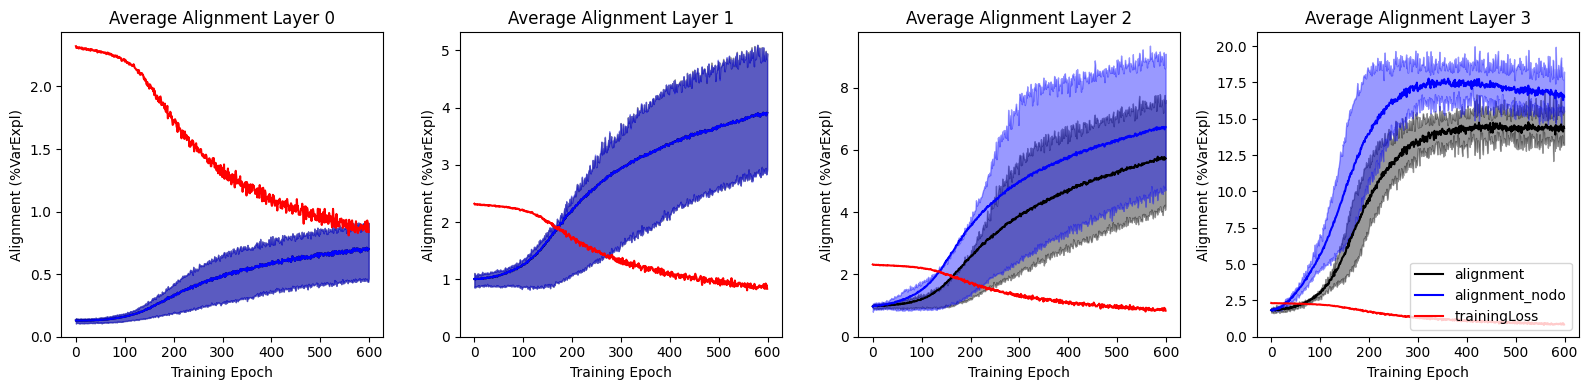

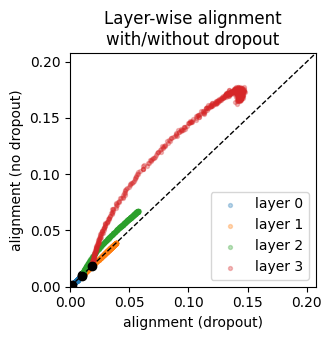

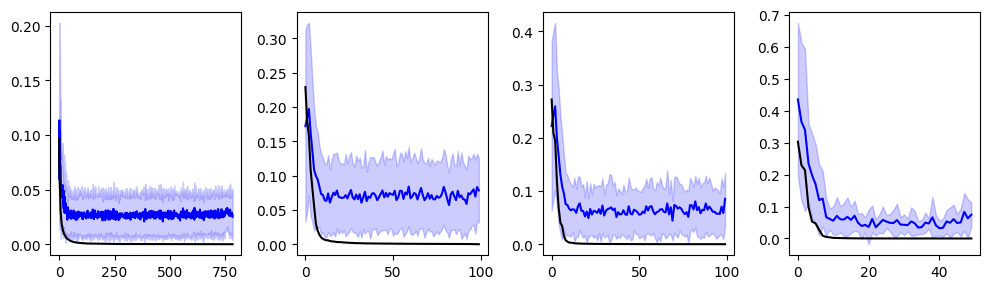

In [65]:
na.plot_training_alignment('config.yaml')